In [13]:
import numpy as np
from qutip import qeye, destroy, tensor, Qobj, basis
from qutip.core.gates import *
from qutip import *
import json
import numpy as np
from numpy import real
from matplotlib import pyplot as plt
from numpy import array
from numpy import real


pi = np.pi
au_to_inv_cm = 219474.63

# -----------------------------------------------------------
# Utility functions
# -----------------------------------------------------------
# -----------------------------------------------------------
# Utility functions
# -----------------------------------------------------------

def read_json_to_dict(filename: str) -> dict:
    """ Read a JSON file into a Python dictionary. """
    with open(filename, "r") as f:
        return json.load(f)

def ladder_operators(dim):
    """ Create ladder operators for a given dimension, return them as numpy arrays. """
    a = destroy(dim)
    adag = a.dag()
    return a.full(), adag.full()

def _tensor(*ops):
    """Kronecker product of multiple operators (NumPy arrays)."""
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result

def build_projector(vectors, i, j):
    """Build projector |i><j| from the i-th and j-th eigenvectors from the supplied set of vectors."""
    ket = vectors[:, i][:, np.newaxis]
    bra = vectors[:, j][:, np.newaxis].conj().T

    projector = ket @ bra
    return projector

def build_qubit_vibronic_coupling(omega_list, gv, boson_dim, qubit_number=1):
    """ Builds the qubit-vibrational and qubit-vibronic coupling Hamiltonian terms
    
        Parameters
        ----------
        omega_list : numpy array of floats
            the fundamental vibrational frequencies associated with the |g> and |e> states of the qubit

        gv : float
            the vibronic coupling between the |g,n> and |e,m> states of the qubit where n = m +- 1

        boson_dim : int
            the number of vibrational Fock states 

        qubit_number : int
            qubit_number=1 will build term for qubit 1, qubit_number=2 will build term for qubit 2
            basis order is q1, cav, q2, v1, v2
    
    """
    # identities as numpy arrays
    Iq_np = np.eye(2)
    Ic_np = np.eye(boson_dim)
    Iv_np = np.eye(boson_dim)

    # ladder and number operators for vibrations
    a_np, adag_np = ladder_operators(boson_dim)
    n_np = adag_np @ a_np

    total_dim = 2 * boson_dim * 2 * boson_dim * boson_dim
    H_vib = np.zeros((total_dim, total_dim), dtype=complex)
    H_vib_coup = np.zeros_like(H_vib)

    # loop over qubit states for vibrational Hamiltonian
    for i in range(2):
        Proj_ii = build_projector(Iq_np, i, i)
        if qubit_number==1:
            op_n = _tensor(Proj_ii, Ic_np, Iq_np, n_np, Iv_np)
        elif qubit_number==2:
            op_n = _tensor(Iq_np, Ic_np, Proj_ii, Iv_np, n_np)

        H_vib += omega_list[i] * op_n

    # only 1 vibronic coupling term
    Proj_11 = build_projector(Iq_np, 1, 1) 
    if qubit_number==1:
        op_m = _tensor(Proj_11, Ic_np, Iq_np, (a_np + adag_np), Iv_np)
    elif qubit_number==2:
        op_m = _tensor(Iq_np, Ic_np, Proj_11, Iv_np, (a_np + adag_np))

    H_vib_coup = gv * op_m
    qubit_dims = [2, boson_dim, 2, boson_dim, boson_dim]
    return Qobj(H_vib + 0 *H_vib_coup, dims=[qubit_dims, qubit_dims]) 


def build_qubit_cavity_vibronic_coupling(H_qubit_cavity_coupling, omega_list, gv_list, boson_dim, qubit_number=1):
    """ Builds the polariton-vibrational and polariton-vibronic coupling Hamiltonian terms
    
        Parameters
        ----------
        H_qubit_cavity_coupling : numpy array of floats
            the qubit-cavity coupled Hamiltonian (e.g. Pauli-Fierz, or Jaynes-Cummings, or Rabi) that defines the polariton basis

        omega_list : numpy array of floats
            the fundamental vibrational frequencies associated with the polariton states, pol1, pol2, pol3

        gv_list : numpy array of float
            the vibronic coupling between the |pol1,n> and |pol2,m>, |pol3,m> states of the qubit where n = m +- 1

        boson_dim : int
            the number of vibrational Fock states 

        qubit_number : int
            qubit_number=1 will build term for qubit 1, qubit_number=2 will build term for qubit 2
            basis order is q1, cav, q2, v1, v2
    
    """
    ### The problem is H_qubit_cavity_coupling is in the full Hilbert space
    ### but we want it in the qubit-cavity subspace only

    # try tracing out extra degree of freedom
    if qubit_number == 1:
        H_qubit_cavity_coupling = H_qubit_cavity_coupling.ptrace([0,1])
    elif qubit_number == 2:
        H_qubit_cavity_coupling = H_qubit_cavity_coupling.ptrace([1,2])

    # this has polariton dim bc we traced out other degrees of freedom
    H_coup_np = H_qubit_cavity_coupling.full()
    polariton_dim = H_coup_np.shape[0]
    vals, vecs = np.linalg.eigh(H_coup_np)

    # operators on the local bosonic space
    a_np, adag_np = ladder_operators(boson_dim)
    n_np = adag_np @ a_np
    Iq_np = np.eye(2, dtype=complex)
    Iv_np = np.eye(boson_dim, dtype=complex)

    # total Hilbert space if qubit_number == 1: polariton ⊗ qubit2 ⊗ vib1 ⊗ vib2
    # and if                 qubit_number == 2: qubit1 ⊗ polariton ⊗ vib1 ⊗ vib2
    total_dim = polariton_dim * 2 * boson_dim * boson_dim
    H_vib = np.zeros((total_dim, total_dim), dtype=complex)
    H_vib_coup = np.zeros_like(H_vib)

    for i in range(3):  # pol1, pol2 (LP), pol3 (UP)
        Proj_ii = build_projector(vecs, i, i)
        if qubit_number==1:
            op_n = _tensor(Proj_ii, Iq_np, n_np, Iv_np)
        elif qubit_number==2:
            op_n = _tensor(Iq_np, Proj_ii, Iv_np, n_np)

        H_vib += omega_list[i] * op_n

        if i > 0:
            if qubit_number==1:
                op_c = _tensor(Proj_ii, Iq_np, (a_np + adag_np), Iv_np)
            elif qubit_number==2:
                op_c = _tensor(Iq_np, Proj_ii, Iv_np, (a_np + adag_np))
            
            # gv_list[0] -> pol1->pol2, gv_list[1] -> pol1->pol3
            H_vib_coup += gv_list[i-1] * op_c

    qubit_dims = [2, boson_dim, 2, boson_dim, boson_dim]
    return Qobj(H_vib + H_vib_coup, dims=[qubit_dims, qubit_dims])
    
        
# -----------------------------------------------------------
# runner function
# -----------------------------------------------------------
def runner(LiH_params, psi0, rho_qubit_ideal, tlist):
    """
    Run simulation using details stored in LiH_params
    """
    
    # System constants - parsed from the .json file in atomic units
    omega_q1 = LiH_params["w_q1"]
    omega_q2 = LiH_params["w_q2"]
    omega_c =  LiH_params["w_cav"]
    mu_eg = LiH_params["qubit_1_dipole_moments"]["mu_eg"]
    mu_ee = LiH_params["qubit_1_dipole_moments"]["mu_e"]
    mu_gg = LiH_params["qubit_1_dipole_moments"]["mu_g"]

    # size of boson space
    Nf = LiH_params.get("N_boson", 2)
    print(F"Number of bosonic states is {Nf}")

    lz    = LiH_params.get("lambda_z", 0.01)
    print(F"Lambda value is {lz}")

    # get model from json; if not defined, use Pauli-Fierz
    model = LiH_params.get("Model", "Pauli-Fierz")
    print(F"Going to use the {model} model")
    # cavity coupling strength
    g_cav = np.sqrt(omega_c / 2) * lz * np.abs(mu_eg)

    # vibrational constants parsed from the .json in cm^-1, converting here
    omega_v_S0 = LiH_params["w_vibS0_cm-1"] / au_to_inv_cm
    omega_v_S1 = LiH_params["w_vibS1_cm-1"] / au_to_inv_cm
    omega_v_pol1 = LiH_params["w_vib1_cm-1"] / au_to_inv_cm
    omega_v_pol2 = LiH_params["w_vib2_cm-1"] / au_to_inv_cm
    omega_v_pol3 = LiH_params["w_vib3_cm-1"] / au_to_inv_cm

    # store these omegas to lists for the qubit and polariton vibrational Hamiltonians
    qubit_omega_list = np.array([omega_v_S0, omega_v_S1])
    polariton_omega_list = np.array([omega_v_pol1, omega_v_pol2, omega_v_pol3])

    print_option = True
    if print_option:
        print(F"omega_v for S0 state is   {omega_v_S0} a.u.")
        print(F"omega_v for S1 state is   {omega_v_S1} a.u.")
        print(F"omega_v for pol1 state is {omega_v_pol1} a.u.")
        print(F"omega_v for pol2 state is {omega_v_pol2} a.u.")
        print(F"omega_v for pol3 state is {omega_v_pol3} a.u.")

    # Huang-Rhys factors
    S_S0S1 = LiH_params["S_S0S1"]
    S_GLP  = LiH_params["S_GLP"]
    S_GUP  = LiH_params["S_GUP"]
    
    # vibrational coupling constants
    # for molecule outside cavity
    qubit_gv = np.sqrt(S_S0S1) * omega_v_S0

    # for molecule coupled to cavity
    polariton_gv = np.zeros(2)
    polariton_gv[0] = np.sqrt(S_GLP) * omega_v_pol1
    polariton_gv[1] = np.sqrt(S_GUP) * omega_v_pol1

    # these are optimal gate times for J-C coupling, but often not optimal for more complicated coupling
    T_gate_1, T_gate_2 = pi / (4 * g_cav), pi / (2 * g_cav)
    #T_gate_1 = 49.57438791 * 1.18
    #T_gate_2 = 148.03856926 * 0.8
    T_gate_1 *= 0.75
    T_gate_2 *= 1.0
    
    global T0_1, T0_2
    T0_1 = 80
    T0_2 = T0_1 + T_gate_1

  
    d_matrix_fixed = lz * np.array([[mu_gg, mu_eg], [mu_eg, mu_ee]])
    d_qobj = Qobj(d_matrix_fixed)

    # Local operators
    sz, sm, sp = sigmaz(), destroy(2), destroy(2).dag()
    nq = sp * sm
    am, ap = destroy(Nf), destroy(Nf).dag()
    nc = ap * am
    Iq, Ic, Iv = qeye(2), qeye(Nf), qeye(Nf)

    # operators in the full Hilbert space for expectation values
    ncav = tensor(Iq, nc, Iq, Iv, Iv)
    nq1 = tensor(nq, Ic, Iq, Iv, Iv)
    nq2 = tensor(Iq, Ic, nq, Iv, Iv)

    # Build Hamiltonians for bare qubits and cavity
    H_q1 = tensor(-omega_q1 / 2 * sz, Ic, Iq, Iv, Iv)
    H_cav = tensor(Iq, omega_c * nc, Iq, Iv, Iv)
    H_q2 = tensor(Iq, Ic, -omega_q2 / 2 * sz, Iv, Iv)

    # build Hamiltonians for qubit-cavity coupling
    if model=="Pauli-Fierz": # blc has full dipole operator, has dse
        H_q1_cav = -np.sqrt(omega_c / 2) * tensor(d_qobj, (am + ap), Iq, Iv, Iv) + 0.5 * tensor(d_qobj * d_qobj, Ic, Iq, Iv, Iv)
        H_q2_cav = -np.sqrt(omega_c / 2) * tensor(Iq, (am + ap), d_qobj, Iv, Iv) + 0.5 * tensor(Iq, Ic, d_qobj * d_qobj, Iv, Iv)
    elif model=="Rabi": # blc has full dipole operator, no dse
        H_q1_cav = -np.sqrt(omega_c / 2) * tensor(d_qobj, (am + ap), Iq, Iv, Iv) 
        H_q2_cav = -np.sqrt(omega_c / 2) * tensor(Iq, (am + ap), d_qobj, Iv, Iv)

    elif model=="Jaynes-Cummings": # blc only has rotating terms, no dse
        H_q1_cav = g_cav * tensor(sp, am, Iq, Iv, Iv) + g_cav * tensor(sm, ap, Iq, Iv, Iv)
        H_q2_cav = g_cav * tensor(Iq, am, sp, Iv, Iv) + g_cav * tensor(Iq, ap, sm, Iv, Iv)

    else: # default to Pauli-Fierz
        H_q1_cav = -np.sqrt(omega_c / 2) * tensor(d_qobj, (am + ap), Iq, Iv, Iv) + 0.5 * tensor(d_qobj * d_qobj, Ic, Iq, Iv, Iv)
        H_q2_cav = -np.sqrt(omega_c / 2) * tensor(Iq, (am + ap), d_qobj, Iv, Iv) + 0.5 * tensor(Iq, Ic, d_qobj * d_qobj, Iv, Iv)

    # build vibrational Hamiltonians for the qubits
    H_q1_vib = build_qubit_vibronic_coupling(qubit_omega_list, qubit_gv, Nf, qubit_number=1)
    H_q2_vib = build_qubit_vibronic_coupling(qubit_omega_list, qubit_gv, Nf, qubit_number=2)
    
    # build the vibrational Hamiltonians for the polaritons
    H_pol1_vib = build_qubit_cavity_vibronic_coupling((H_q1_cav + H_q1 + H_cav), polariton_omega_list, polariton_gv, Nf, qubit_number=1)
    H_pol2_vib = build_qubit_cavity_vibronic_coupling((H_q2_cav + H_q2 + H_cav), polariton_omega_list, polariton_gv, Nf, qubit_number=2)

    # Time-dependent Hamiltonian parts
    def wc_t(t, args=None): return 1 if t <= T0_1 else 0
    def w1_t(t, args=None): return 1 if T0_1 < t <= T0_1 + T_gate_1 else 0
    def w2_t(t, args=None): return 1 if T0_2 < t <= T0_2 + T_gate_2 else 0

    H_uncoupled = H_q1 + H_cav + H_q2 + H_q1_vib + H_q2_vib
    H_q1_cav_coupled = H_q1 + H_cav + H_q1_cav + H_pol1_vib + H_q2 + H_q2_vib
    H_q2_cav_coupled = H_q1 + H_cav + H_q1_vib + H_q2 + H_q2_cav + H_pol2_vib

    H_t_PF = [[H_uncoupled, wc_t], [H_q1_cav_coupled, w1_t], [H_q2_cav_coupled, w2_t]]

    res = mesolve(H_t_PF, psi0, tlist, [], e_ops=[])


    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

    axes[0].plot(tlist, array(list(map(wc_t, tlist))), 'r', linewidth=2, label="cavity")
    axes[0].plot(tlist, array(list(map(w1_t, tlist))), 'b', linewidth=2, label="qubit 1")
    axes[0].plot(tlist, array(list(map(w2_t, tlist))), 'g', linewidth=2, label="qubit 2")
    #axes[0].set_ylim(1, 6)
    axes[0].set_ylabel("Energy (a.u.)", fontsize=16)
    axes[0].legend()

    axes[1].plot(tlist, real(expect(ncav, res.states)), 'r', linewidth=2, label="cavity")
    axes[1].plot(tlist, real(expect(nq1, res.states)), 'b', linewidth=2, label="qubit 1")
    axes[1].plot(tlist, real(expect(nq2, res.states)), 'g', linewidth=2, label="qubit 2")
    axes[1].set_xlabel("Time (a.u.)", fontsize=16)
    axes[1].set_ylabel("Occupation probability", fontsize=16)
    axes[1].legend()

    fig.tight_layout()


    rho_final = res.states[-1]

    rho_qubits = ptrace(rho_final, [0,2])
    print(rho_qubits)
    fide = fidelity(rho_qubits, rho_qubit_ideal)
    conc = concurrence(rho_qubits)

    print(F"fidelity is {fide}")
    print(F"concurrence is {conc}")
    print(F"Final rho is \n {rho_qubits}")

    return rho_qubits, fide, conc

Number of bosonic states is 5
Lambda value is 0.01
Going to use the Jaynes-Cummings model
omega_v for S0 state is   0.006229102653003676 a.u.
omega_v for S1 state is   0.001650896962441627 a.u.
omega_v for pol1 state is 0.006291980079884404 a.u.
omega_v for pol2 state is 0.0019347110871083368 a.u.
omega_v for pol3 state is 0.005663524754546801 a.u.
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.1770598 +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.34633128+0.j         0.01151301+0.01060823j
  0.        +0.j        ]
 [0.        +0.j         0.01151301-0.01060823j 0.47660892+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]]
fidelity is 0.6324216128082905
concurrence is 0.03131031342933105
Final rho is 
 Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data

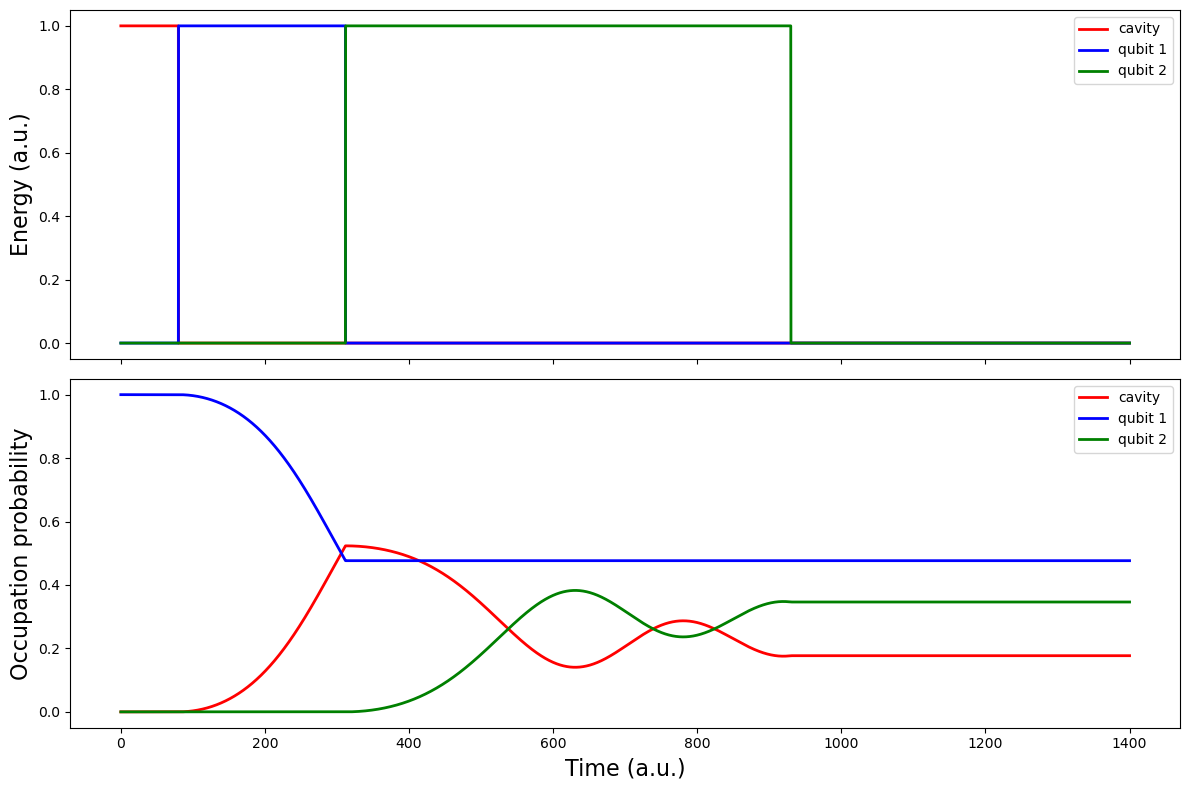

In [14]:
# -----------------------------------------------------------
# Load system parameters (LiH example)
# -----------------------------------------------------------
LiH_params = read_json_to_dict("LiH_lz_0.05.json")


Nf = LiH_params.get("N_boson", 3)

psi_init = tensor(basis(2,1), basis(Nf,0),
              basis(2,0), basis(Nf,0), basis(Nf,0))


# ideal Bell target
rho_qubits_ideal = ket2dm(
    tensor(phasegate(0), phasegate(pi/2)) *
    sqrtiswap() *
    tensor(basis(2,1), basis(2,0))
)

# time discretization
tlist = np.linspace(0, 1400, 5000)

rf, fid, con = runner(LiH_params, psi_init, rho_qubits_ideal, tlist)

In [15]:
rf

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.1770598 +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.34633128+0.j         0.01151301+0.01060823j
  0.        +0.j        ]
 [0.        +0.j         0.01151301-0.01060823j 0.47660892+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]]